In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data_path = "../../data/raw/ai_job_dataset.csv"  

# Load dataset
data = pd.read_csv(data_path)

In [3]:
np.random.seed(42)

missingness = {
    "education_required": 0.09,   # 9% missing
    "years_experience": 0.11,     # 11% missing
    "employee_residence": 0.06,   # 6% missing
    "benefits_score": 0.04,       # 4% missing
    "required_skills": 0.075,     # 7.5% missing
    "posting_date": 0.0875,       # 8.75% missing
    "salary_usd": 0.02            # 2% missing
}

for col, frac in missingness.items():
    n_missing = int(len(data) * frac)
    missing_indices = np.random.choice(data.index, size=n_missing, replace=False)
    data.loc[missing_indices, col] = np.nan

In [4]:
data.isnull().sum()

job_id                       0
job_title                    0
salary_usd                 300
salary_currency              0
salary_local                 0
experience_level             0
employment_type              0
company_location             0
company_size                 0
employee_residence         900
remote_ratio                 0
required_skills           1125
education_required        1350
years_experience          1650
industry                     0
posting_date              1312
application_deadline         0
job_description_length       0
benefits_score             600
company_name                 0
dtype: int64

In [5]:
target = "salary_usd"

# Remove irrelevant columns
drop_cols = ["application_date", "salary_local", "salary_currency", "job_description_length"]
for col in drop_cols:
    if col in data.columns:
        data = data.drop(columns=col)

# Convert posting_date
data["posting_date"] = pd.to_datetime(data["posting_date"], errors="coerce")

In [6]:
data = data.dropna(subset=[target])
train, temp = train_test_split(data, test_size=0.30, random_state=42)
val, test = train_test_split(temp, test_size=0.50, random_state=42)

print(len(train), len(val), len(test))

10290 2205 2205


In [7]:
num_features = ["years_experience", "benefits_score"]
cat_features = ["experience_level", "employment_type", "company_size",
                "employee_residence", "education_required"]

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

In [9]:
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

In [10]:
#random forest
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

In [11]:
gbr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

In [12]:
models = {
    "Linear Regression": linreg_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gbr_model
}

results = {}

for name, model in models.items():
    model.fit(train[num_features + cat_features], train[target])
    preds = model.predict(val[num_features + cat_features])

    rmse = np.sqrt(mean_squared_error(val[target], preds))
    mae = mean_absolute_error(val[target], preds)

    results[name] = {"RMSE": rmse, "MAE": mae}

In [13]:
pd.DataFrame(results).T.sort_values(by="RMSE")

,RMSE,MAE
Gradient Boosting,30027.483887,20530.253651
Linear Regression,31716.812866,21885.912335
Random Forest,32423.948206,22149.477294


In [14]:
models["Gradient Boosting"].named_steps

{'preprocess': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['years_experience', 'benefits_score']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['experience_level', 'employment_type',
                                   'company_size', 'employee_residence',
                                   'education_required'])]),
 'model': GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)}

In [15]:
gb_model = models["Gradient Boosting"]

# Pull out the actual regressor
final_model = gb_model.named_steps["model"]

# Feature importances from the GB model
importances = final_model.feature_importances_

# Get feature names from the preprocessor
feature_names = gb_model.named_steps["preprocess"].get_feature_names_out()

# Display sorted importances
for name, score in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {score:.4f}")

cat__experience_level_EX: 0.6067
cat__experience_level_SE: 0.1109
cat__employee_residence_India: 0.0548
cat__employee_residence_China: 0.0479
cat__company_size_L: 0.0422
cat__employee_residence_Switzerland: 0.0283
cat__experience_level_EN: 0.0201
cat__experience_level_MI: 0.0157
cat__employee_residence_Norway: 0.0139
cat__employee_residence_Denmark: 0.0139
num__years_experience: 0.0135
cat__company_size_S: 0.0131
cat__employee_residence_United States: 0.0046
num__benefits_score: 0.0038
cat__employee_residence_South Korea: 0.0033
cat__employee_residence_Singapore: 0.0010
cat__employee_residence_United Kingdom: 0.0009
cat__employee_residence_Netherlands: 0.0007
cat__employee_residence_Israel: 0.0006
cat__employee_residence_Japan: 0.0006
cat__employee_residence_France: 0.0005
cat__employee_residence_Austria: 0.0004
cat__education_required_PhD: 0.0003
cat__employment_type_FL: 0.0003
cat__education_required_Master: 0.0002
cat__employee_residence_Finland: 0.0002
cat__employee_residence_Italy

In [16]:
#random forest tuning
from sklearn.model_selection import RandomizedSearchCV
rf_pipeline = models["Random Forest"]

rf_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": [None, "sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42
)

rf_search.fit(train[num_features + cat_features], train[target])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [5, 10, ...], 'model__max_features': [None, 'sqrt', ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [17]:
#gradient boosting tuning
gb_pipeline = models["Gradient Boosting"]

gb_params = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [2, 3, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0]
}

gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=gb_params,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=1,
    random_state=42
)

gb_search.fit(train[num_features + cat_features], train[target])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [2, 3, ...], 'model__n_estimators': [100, 200, ...], 'model__subsample': [0.8, 1.0]}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## Full Evaluation

In [18]:
#linear regression predictions
linreg = models["Linear Regression"]
linreg.fit(train[num_features + cat_features], train[target])

linreg_pred_test = linreg.predict(test[num_features + cat_features])

In [19]:
#best random forest from tuning 
best_rf = rf_search.best_estimator_
rf_pred_test = best_rf.predict(test[num_features + cat_features])

In [20]:
#best gradient boosting from tuning 
best_gb = gb_search.best_estimator_
gb_pred_test = best_gb.predict(test[num_features + cat_features])

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return rmse, mae

linreg_rmse, linreg_mae = evaluate(test[target], linreg_pred_test)
rf_rmse, rf_mae         = evaluate(test[target], rf_pred_test)
gb_rmse, gb_mae         = evaluate(test[target], gb_pred_test)

print("LINEAR REGRESSION → RMSE:", linreg_rmse, " MAE:", linreg_mae)
print("RANDOM FOREST     → RMSE:", rf_rmse,     " MAE:", rf_mae)
print("GRADIENT BOOST    → RMSE:", gb_rmse,     " MAE:", gb_mae)

LINEAR REGRESSION → RMSE: 30770.12319330667  MAE: 21486.3174327208
RANDOM FOREST     → RMSE: 29804.286766357014  MAE: 20742.061860132435
GRADIENT BOOST    → RMSE: 29224.605392494577  MAE: 20146.740880756483


In [22]:
#Training RMSE
def train_rmse(model, X, y):
    pred = model.predict(X)
    return np.sqrt(mean_squared_error(y, pred))

linreg_train_rmse = train_rmse(linreg, train[num_features + cat_features], train[target])
rf_train_rmse     = train_rmse(best_rf, train[num_features + cat_features], train[target])
gb_train_rmse     = train_rmse(best_gb, train[num_features + cat_features], train[target])

In [23]:
print("TRAIN RMSE:")
print("  Linear Regression:", linreg_train_rmse)
print("  Random Forest:    ", rf_train_rmse)
print("  Gradient Boosting:", gb_train_rmse)
print()

TRAIN RMSE:
  Linear Regression: 31256.714948039695
  Random Forest:     26379.96742854426
  Gradient Boosting: 29226.999304482237



In [24]:
#Validation RMSE (from CV)
rf_val_rmse = -rf_search.best_score_
gb_val_rmse = -gb_search.best_score_

In [25]:
from sklearn.model_selection import cross_val_score

linreg_cv_rmse = -cross_val_score(
    linreg,
    train[num_features + cat_features],
    train[target],
    cv=3,
    scoring="neg_root_mean_squared_error"
).mean()

linreg_cv_mae = -cross_val_score(
    linreg,
    train[num_features + cat_features],
    train[target],
    cv=3,
    scoring="neg_mean_absolute_error"
).mean()

In [26]:
print("VALIDATION RMSE:")
print("  Linear Regression:", linreg_cv_rmse)
print("  Random Forest:    ", rf_val_rmse)
print("  Gradient Boosting:", gb_val_rmse)
print()

VALIDATION RMSE:
  Linear Regression: 31899.2311783005
  Random Forest:     31044.24977166943
  Gradient Boosting: 30462.096598459084



In [27]:
print("VALIDATION MAE:")
print("  Linear Regression:", linreg_cv_mae)
print("  Random Forest:    ", rf_val_rmse)
print("  Gradient Boosting:", gb_val_rmse)
print()

VALIDATION MAE:
  Linear Regression: 22244.2625484688
  Random Forest:     31044.24977166943
  Gradient Boosting: 30462.096598459084



In [28]:
print("TEST RMSE:")
print("  Linear Regression:", linreg_rmse)
print("  Random Forest:    ", rf_rmse)
print("  Gradient Boosting:", gb_rmse)
print()

TEST RMSE:
  Linear Regression: 30770.12319330667
  Random Forest:     29804.286766357014
  Gradient Boosting: 29224.605392494577



In [29]:
print("TEST MAE:")
print("  Linear Regression:", linreg_mae)
print("  Random Forest:    ", rf_mae)
print("  Gradient Boosting:", gb_mae)

TEST MAE:
  Linear Regression: 21486.3174327208
  Random Forest:     20742.061860132435
  Gradient Boosting: 20146.740880756483


### Random Forest Feature Importances

In [30]:
#Extract the preprocessing step
preprocess = best_rf.named_steps["preprocess"]

# Get numerical and one-hot encoded categorical feature names
num_cols = preprocess.transformers_[0][2]
cat_cols = preprocess.transformers_[1][1].get_feature_names_out(preprocess.transformers_[1][2])

all_feature_names = list(num_cols) + list(cat_cols)

# Extract importances from RF model
rf_model = best_rf.named_steps["model"]
rf_importances = rf_model.feature_importances_

import pandas as pd

rf_feat_imp = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf_importances
}).sort_values("Importance", ascending=False)

print("Top 20 RF Features:")
print(rf_feat_imp.head(20))

Top 20 RF Features:
                             Feature  Importance
3                experience_level_EX    0.277886
0                   years_experience    0.226569
2                experience_level_EN    0.144972
4                experience_level_MI    0.050966
31          employee_residence_India    0.044923
5                experience_level_SE    0.042963
20          employee_residence_China    0.039893
10                    company_size_L    0.028801
56    employee_residence_Switzerland    0.024673
12                    company_size_S    0.017130
1                     benefits_score    0.014337
23        employee_residence_Denmark    0.012277
45         employee_residence_Norway    0.011983
11                    company_size_M    0.005667
61  employee_residence_United States    0.004299
53    employee_residence_South Korea    0.003459
7                 employment_type_FL    0.002316
66            education_required_PhD    0.002307
6                 employment_type_CT    0.002188


### Gradient Boosting Feature Importances

In [31]:
gb_model = best_gb.named_steps["model"]
gb_importances = gb_model.feature_importances_

gb_feat_imp = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": gb_importances
}).sort_values("Importance", ascending=False)

print("Top 20 GB Features:")
print(gb_feat_imp.head(20))

Top 20 GB Features:
                              Feature  Importance
3                 experience_level_EX    0.602174
5                 experience_level_SE    0.109328
31           employee_residence_India    0.055476
20           employee_residence_China    0.048687
10                     company_size_L    0.042698
56     employee_residence_Switzerland    0.029307
2                 experience_level_EN    0.026275
23         employee_residence_Denmark    0.014259
0                    years_experience    0.014191
45          employee_residence_Norway    0.014151
12                     company_size_S    0.014046
4                 experience_level_MI    0.010258
61   employee_residence_United States    0.004680
53     employee_residence_South Korea    0.003430
1                      benefits_score    0.003367
51       employee_residence_Singapore    0.001144
60  employee_residence_United Kingdom    0.000870
42     employee_residence_Netherlands    0.000710
34          employee_residence

### Final Comparison (Same values as above)

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_rmse(model, X_train, y_train, X_val, y_val, X_test, y_test):
    train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    val_rmse   = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))
    test_rmse  = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return train_rmse, val_rmse, test_rmse

rf_rmse = get_rmse(
    best_rf,
    train[num_features + cat_features],
    train[target],
    val[num_features + cat_features],
    val[target],
    test[num_features + cat_features],
    test[target]
)

gb_rmse = get_rmse(
    best_gb,
    train[num_features + cat_features],
    train[target],
    val[num_features + cat_features],
    val[target],
    test[num_features + cat_features],
    test[target]
)

def print_rmse(name, rmse_tuple):
    train, val, test = rmse_tuple
    print(f"{name} RMSE:")
    print(f"  Train RMSE: {train:,.2f}")
    print(f"  Val   RMSE: {val:,.2f}")
    print(f"  Test  RMSE: {test:,.2f}\n")

print_rmse("Random Forest", rf_rmse)
print_rmse("Gradient Boosting", gb_rmse)

Random Forest RMSE:
  Train RMSE: 26,379.97
  Val   RMSE: 30,257.64
  Test  RMSE: 29,804.29

Gradient Boosting RMSE:
  Train RMSE: 29,227.00
  Val   RMSE: 30,052.85
  Test  RMSE: 29,224.61



## Clustering

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# -----------------------
# 1. Use previous preprocessing pipeline (without model)
# -----------------------
preprocess_only = preprocess  # from earlier code

X_cluster = preprocess_only.fit_transform(data[num_features + cat_features])

X_cluster.shape

(14700, 67)

In [34]:
### Run K means for different K values
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_cluster)
    inertias.append(km.inertia_)

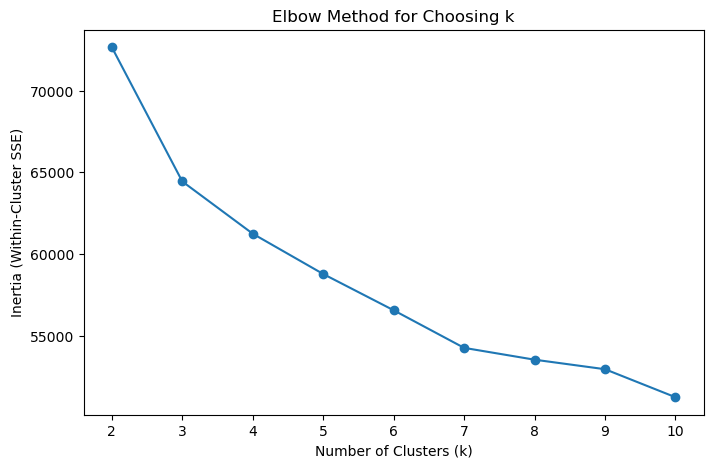

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method for Choosing k")
plt.show()

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)
data['cluster'] = kmeans.fit_predict(X_cluster)

In [37]:
numeric_cols = num_features  # e.g., ['years_experience', 'benefits_score']
categorical_cols = cat_features  # e.g., ['experience_level', 'employment_type', ...]

# Numeric summary
numeric_summary = data.groupby('cluster')[numeric_cols].mean()

# Categorical summary: get the mode (most frequent value) per cluster
categorical_summary = data.groupby('cluster')[categorical_cols] \
                          .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Combine
cluster_summary = pd.concat([numeric_summary, categorical_summary], axis=1)
print(cluster_summary)

         years_experience  benefits_score experience_level employment_type  \
cluster                                                                      
0                7.057012        6.232697               SE              PT   
1               14.712810        6.155716               EX              CT   
2                3.045500        6.471764               MI              PT   
3                7.010381        8.735338               SE              PT   
4                0.509406        6.533997               EN              CT   
5                1.788139        8.988881               MI              CT   
6               14.445809        8.691009               EX              FL   

        company_size employee_residence education_required  
cluster                                                     
0                  L             Canada           Bachelor  
1                  L              China           Bachelor  
2                  L             Canada           Bac

In [38]:
cluster_labels = {
    0: "Mid-Level Large Co (Canada)",
    1: "Senior Executive Large Company (China)",
    2: "Junior Mid-Level Large Company (Canada)",
    3: "Mid-Senior Medium Company (Singapore)",
    4: "Entry-Level Small Company (UK)",
    5: "Early-Career Research (Ireland)",
    6: "Senior Experienced Medium Company (France)"
}

In [39]:
data_copy = data
data_copy["cluster_label"] = data_copy["cluster"].map(cluster_labels)
data_copy.head(10)

,job_id,job_title,salary_usd,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,benefits_score,company_name,cluster,cluster_label
0,AI00001,Data Scientist,219728.0,EX,PT,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13.0,Transportation,2024-09-23,2024-10-31,6.6,TechCorp Inc,1,Senior Executive Large Company (China)
1,AI00002,Head of AI,230237.0,EX,PT,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10.0,Transportation,2024-07-26,2024-09-12,8.5,Cloud AI Solutions,6,Senior Experienced Medium Company (France)
2,AI00003,Data Engineer,128890.0,EX,CT,Germany,S,Germany,100,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,NaN,Automotive,2025-01-19,2025-03-28,5.5,Quantum Computing Inc,0,Mid-Level Large Co (Canada)
3,AI00004,Computer Vision Engineer,96349.0,MI,FL,Finland,L,Finland,50,"MLOps, Linux, Tableau, Python",PhD,2.0,Automotive,2024-07-20,2024-09-06,6.8,Cognitive Computing,2,Junior Mid-Level Large Company (Canada)
4,AI00005,Robotics Engineer,63065.0,EN,FT,France,S,France,100,"R, Scala, SQL, GCP, Python",Associate,0.0,Finance,2025-03-16,2025-05-09,9.3,Advanced Robotics,5,Early-Career Research (Ireland)
5,AI00006,Data Scientist,111794.0,SE,CT,Singapore,S,Norway,50,"NLP, MLOps, TensorFlow",Master,7.0,Technology,2024-11-10,2025-01-20,5.1,Cloud AI Solutions,0,Mid-Level Large Co (Canada)
6,AI00007,AI Consultant,113897.0,SE,PT,Canada,L,Poland,50,"PyTorch, Linux, NLP",Associate,NaN,Gaming,2024-02-29,2024-04-21,7.4,AI Innovations,0,Mid-Level Large Co (Canada)
7,AI00008,Head of AI,168639.0,SE,FT,Australia,L,Vietnam,100,"Spark, SQL, Tableau, Computer Vision, Linux",Associate,9.0,Consulting,2024-02-26,2024-03-17,5.5,TechCorp Inc,0,Mid-Level Large Co (Canada)
8,AI00009,Data Scientist,92624.0,MI,FT,Japan,L,Japan,50,"Kubernetes, SQL, Docker, Deep Learning",NaN,4.0,Government,2024-08-18,2024-10-03,9.5,DataVision Ltd,5,Early-Career Research (Ireland)
9,AI00010,Machine Learning Engineer,215627.0,EX,FT,United Kingdom,M,United Kingdom,50,"Git, Scala, GCP",PhD,10.0,Government,2025-01-18,2025-03-20,7.8,DeepTech Ventures,6,Senior Experienced Medium Company (France)


In [40]:
rf_search.best_params_

{'model__n_estimators': 200,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'sqrt',
 'model__max_depth': 20}

In [41]:
gb_search.best_params_

{'model__subsample': 0.8,
 'model__n_estimators': 200,
 'model__max_depth': 3,
 'model__learning_rate': 0.05}

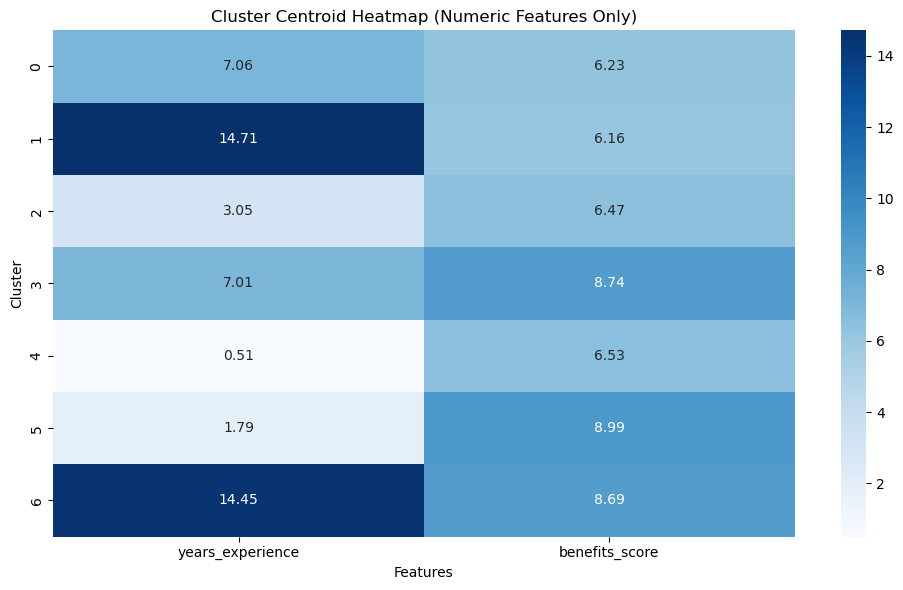

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for the heatmap
numeric_cols = cluster_summary.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Centroid Heatmap (Numeric Features Only)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1989082/2612857929.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


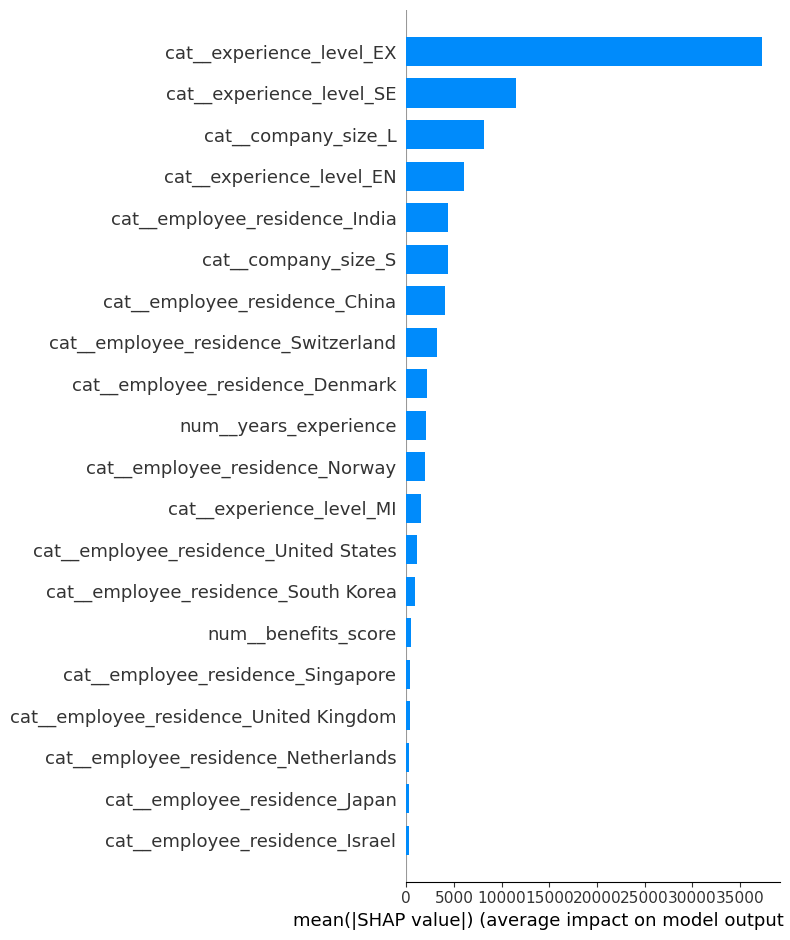

/tmp/ipykernel_1989082/2612857929.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


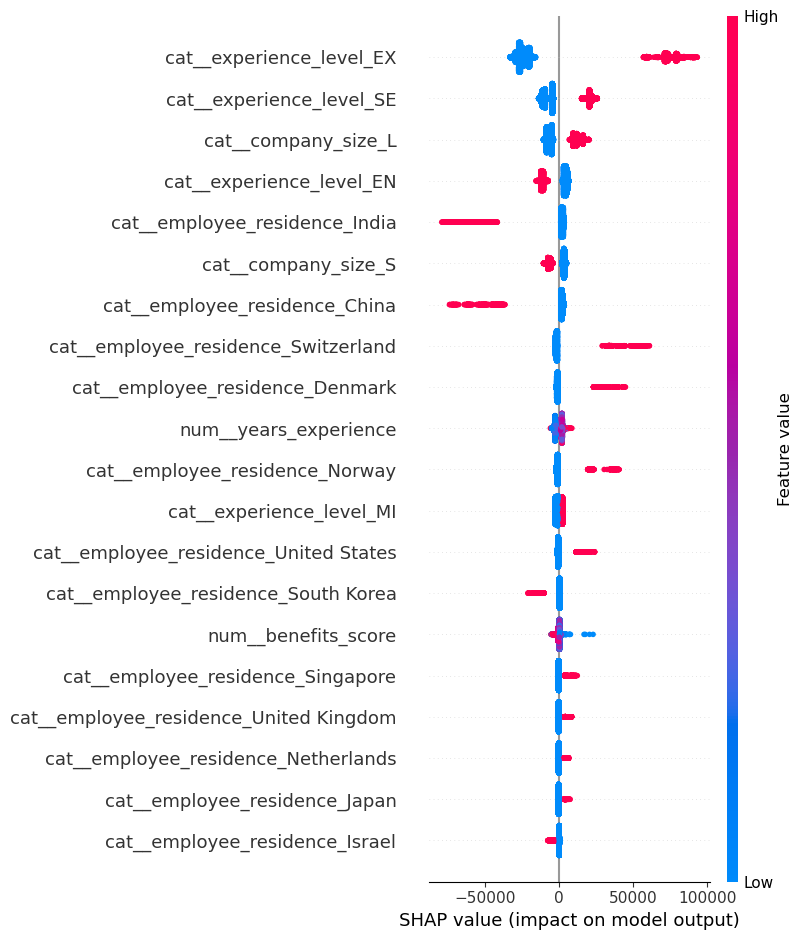

In [47]:
from sklearn.pipeline import Pipeline
import shap

# ---- Step 1: Find the last step (the model) ----
# Assumes last step is the gradient boosting model
gb_model = best_gb.steps[-1][1]

# ---- Step 2: Find the preprocessing step ----
# Assumes everything except last step is preprocessing
preprocessor = Pipeline(best_gb.steps[:-1])

# ---- Step 3: Prepare training data ----
target = "salary_usd"
X_train = train.drop(columns=[target])
y_train = train[target]

# ---- Step 4: Transform X ----
X_train_transformed = preprocessor.transform(X_train)

# Ensure dense numeric array
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

import numpy as np
X_train_transformed = X_train_transformed.astype(np.float64)

# ---- Step 5: Feature names ----
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]

# ---- Step 6: SHAP ----
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_train_transformed)

# ---- Step 7: SHAP plots ----
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)

/tmp/ipykernel_1989082/1442014866.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


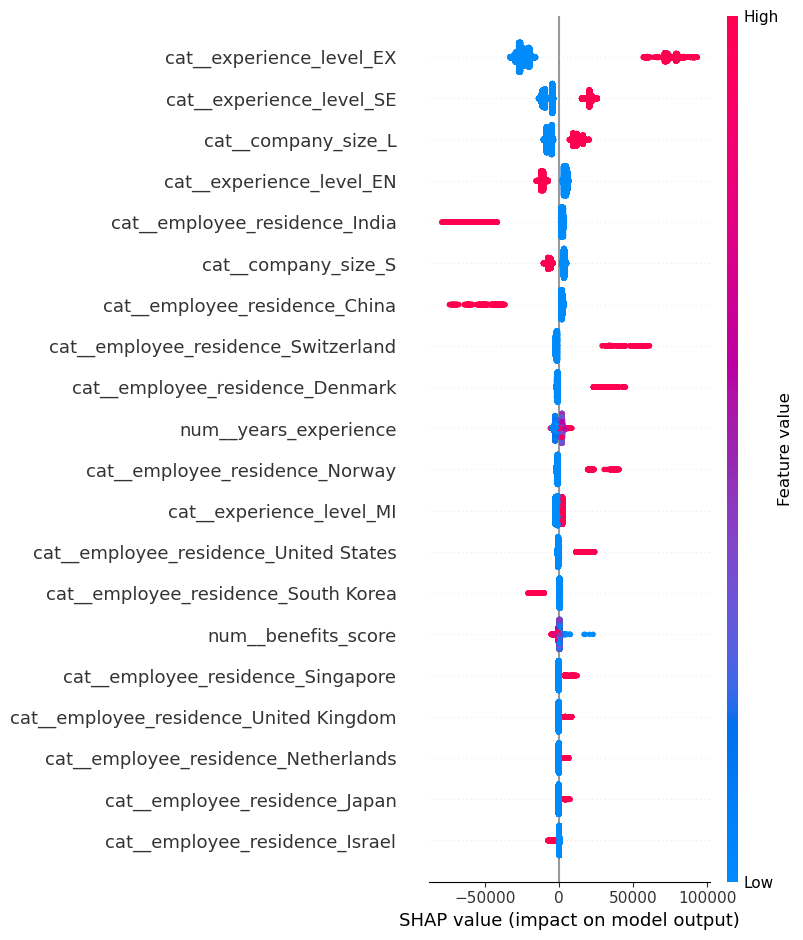

In [48]:
shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)


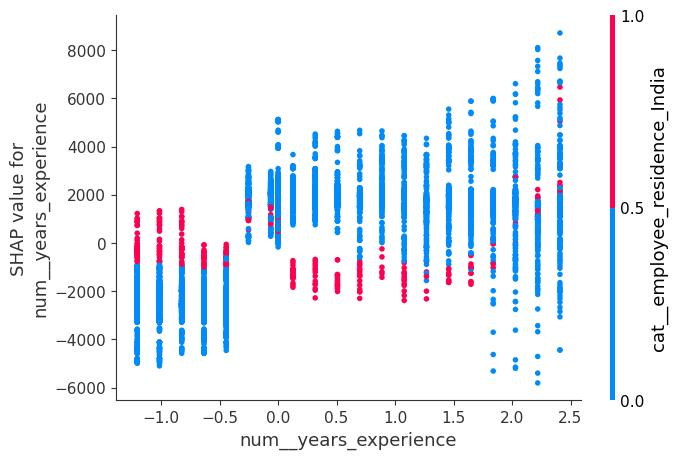

In [51]:
shap.dependence_plot(
    "num__years_experience",
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)
